In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist, pdist
from sklearn.preprocessing import StandardScaler, Normalizer
import warnings
warnings.filterwarnings("ignore")

In [2]:
# configs
data_path = '../02_data/processed/00_pre_modeling_analysis.csv'
save_data_path = '../02_data/processed/01_customer_cluster.csv'

In [3]:
df = pd.read_csv(data_path)
df_aux = deepcopy(df.drop('Dt_Customer', axis=1))

In [4]:
# Fixing datatypes
categorical_columns = ['Response',
                       'Complain',
                       'AcceptedCmp1',             
                       'AcceptedCmp2',             
                       'AcceptedCmp3',            
                       'AcceptedCmp4',             
                       'AcceptedCmp5',
                       'Education',
                       'Marital_Status']

for feature in categorical_columns:
    df_aux[feature] = df_aux[feature].astype('category').cat.codes

In [5]:
df_aux.dtypes

YearsOfEnrollment        int64
Age                      int64
Education                 int8
Marital_Status            int8
Kidhome                  int64
Teenhome                 int64
Recency                  int64
Income                 float64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp1              int8
AcceptedCmp2              int8
AcceptedCmp3              int8
AcceptedCmp4              int8
AcceptedCmp5              int8
Complain                  int8
Response                  int8
accepted_cmp_before      int64
qtd_cmp_accepted         int64
dtype: object

In [6]:
# Generating normalized data
df_aux = df_aux.values

scaler = Normalizer().fit(df_aux)
df_aux = scaler.transform(df_aux)

pca = PCA(n_components=2).fit_transform(df_aux)

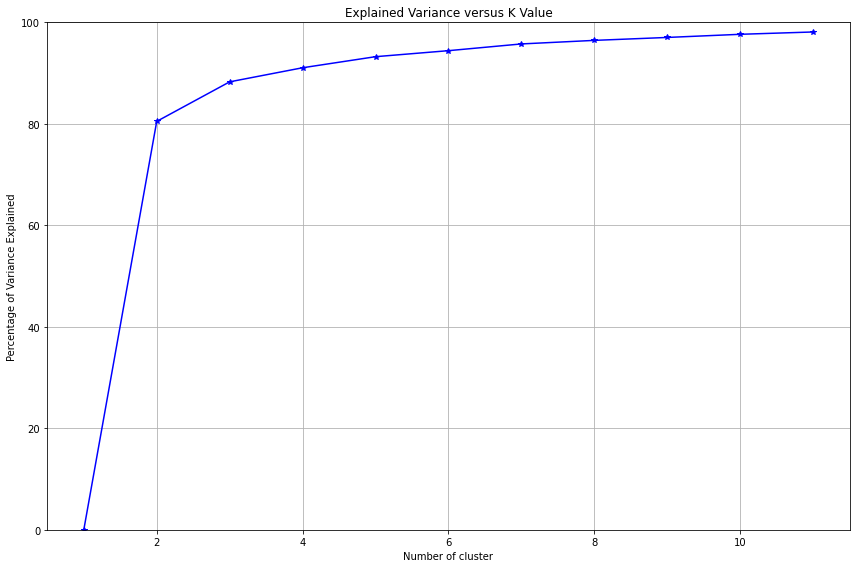

In [7]:
# Plot Size
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(12)

# K range
k_range = range(1, 12)

# Applying the K-Means model to each value of K (this cell can take a long time to run)
k_means_var = [KMeans(n_clusters = k).fit(df_aux) for k in k_range]

# Tuning the cluster centroid for each model
centroids = [X.cluster_centers_ for X in k_means_var]

# Calculating the Euclidean distance from each data point to the centroid
k_euclid = [cdist(df_aux, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke, axis = 1) for ke in k_euclid]

# Sum of the squares of the distances within the cluster
sum_square_intra_cluster = [sum(d**2) for d in dist]

# total sum of squares
total_sum = sum(pdist(df_aux)**2)/df_aux.shape[0]

# total sum of squares
sum_square_inter_cluster = total_sum - sum_square_intra_cluster

# Results Plot
plt.plot(k_range, sum_square_inter_cluster/total_sum * 100, 'b*-')
ax = plt.gca()
ax.set_ylim([0,100])
plt.grid(True)
plt.xlabel('Number of cluster')
plt.ylabel('Percentage of Variance Explained')
plt.title('Explained Variance versus K Value')

fig.tight_layout()
plt.show()

This plot gives us an overview of the optimal K values to use, clearly K values below 3 cannot explain most of the variance between the data.

From the above, an analysis will be made to verify the optimal value of clusters so that there is no overlap of groups.

In [8]:
# Creating a model with K = 3, 4, 5, 6, 7, 8, 9, 10, 11 and 12
models = dict()

# Training the Models
for i in range(3,13):
    m = KMeans(n_clusters = i)
    models.update({'model_k'+str(i) : m.fit(df_aux)})
    
# Print of Results
for key in models.keys():
    labels = models[key].labels_
    print(key,": ",silhouette_score(df_aux, labels, metric = 'euclidean'))

model_k3 :  0.9879437314156411
model_k4 :  0.9881678137348265
model_k5 :  0.9881883992193471
model_k6 :  0.9875455759854621
model_k7 :  0.9869435245140837
model_k8 :  0.9801471925982469
model_k9 :  0.9801370360923158
model_k10 :  0.9801957711245304
model_k11 :  0.9803644085794523
model_k12 :  0.980306657615236


Given the results above, the optimal number of clusters is not very clear, the metric chosen is very close, we will do the plots in 2d to get better conclusions

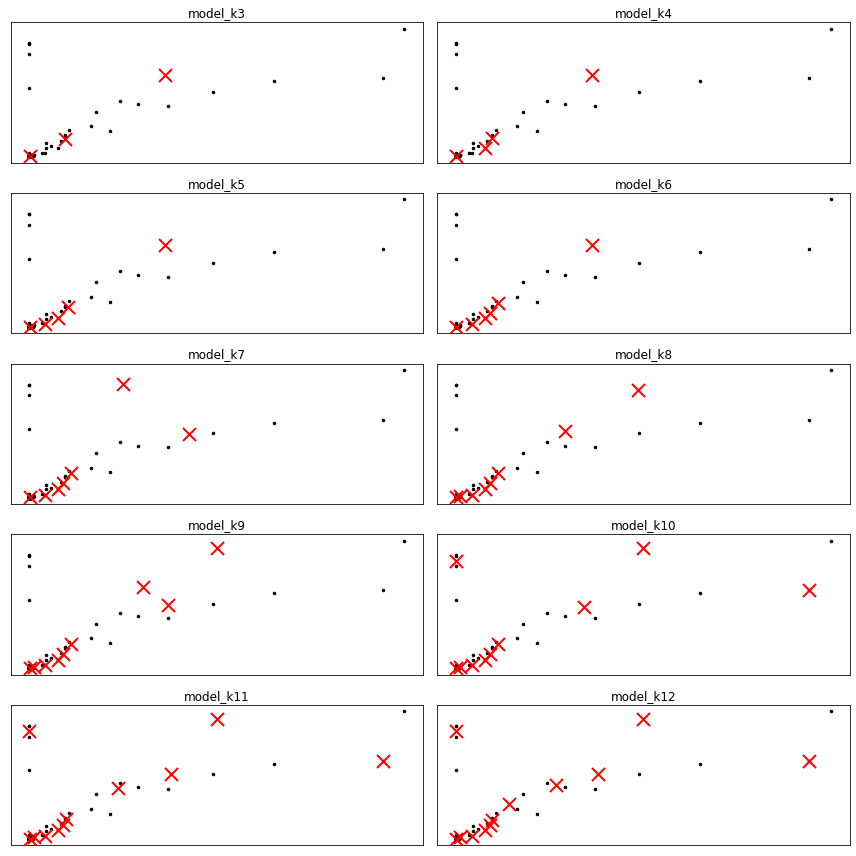

In [9]:
# Setting the size of plots
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(12)

    
# Centroids Plot
for i, model_k in enumerate(models.keys()):
    
    model = models[model_k]
    
    plt.subplot(5,2, i+1)
    plt.plot(df_aux[:, 0], df_aux[:, 1], 'k.', markersize = 5)
    centroids = model.cluster_centers_
    inert = model.inertia_
    plt.scatter(centroids[:, 0], centroids[:, 1], marker = 'x', s = 169, linewidths = 2, color = 'r', zorder = 8)
    plt.title(model_k)
    plt.xticks(())
    plt.yticks(())


fig.tight_layout()
plt.show()

for a number of k greater than 7 the clusters start to overlap sharply

In [10]:
models_of_interest = ['model_k3',
                      'model_k4',
                      'model_k5',
                      'model_k6',
                      'model_k7']

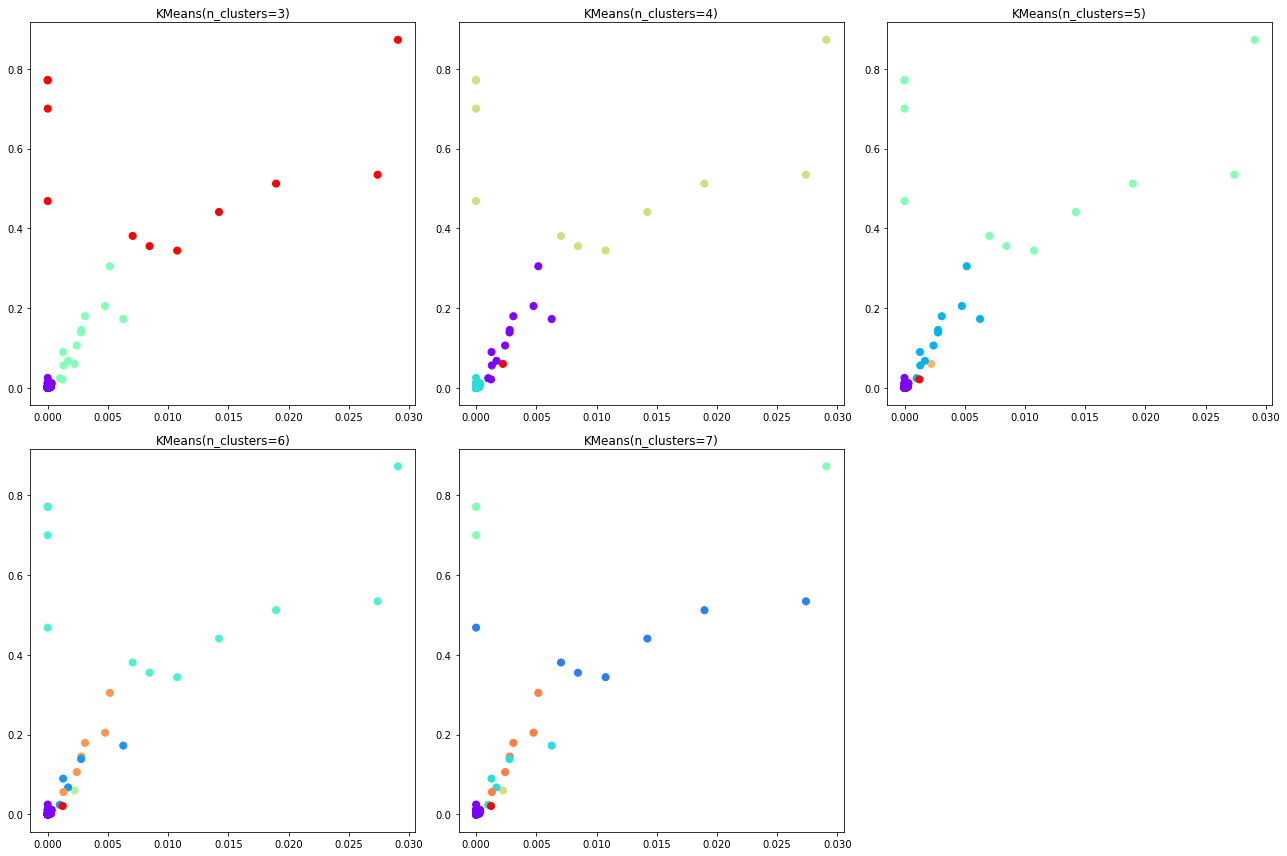

In [11]:
# Plot os Gruops
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(18)

for i, model_k in enumerate(models_of_interest):
    
    model = models[model_k]
    label = model.labels_
    
    plt.subplot(2,3,i+1)
    plt.scatter(df_aux[:, 0], df_aux[:, 1], c=label, s=50, cmap='rainbow')
    plt.title(model)
    
fig.tight_layout()    
plt.show()

with this plot it becomes more visible that the proper number of cluster is 3